# Simple Metropolis-Hastings
chapter 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
import tqdm

%matplotlib inline
sns.set(font_scale=1.5)

In [14]:
def metropolis(func, steps=10000):
    """A very simple Metropolis implementation"""
    samples = np.zeros(steps)
    # start at mean for heck of it
    old_x = func.mean()
    # get the prob density at this point
    old_prob = func.pdf(old_x)
    for i in range(steps):
        # take a small step some direction
        new_x = old_x + np.random.normal(0, 0.5)
        # get the prob density
        new_prob = func.pdf(new_x)
        # compute acceptace parameter
        acceptance = new_prob/old_prob
        # if accepted (bigger than some rangom number)
        # the more better the new point it the higher chance it is accepted
        if acceptance >= np.random.random():
            # keep the new point and make new the old point
            samples[i] = new_x
            old_x = new_x
            old_prob = new_prob
        else:
            # if rejected keep the old point
            samples[i] = old_x
    return samples

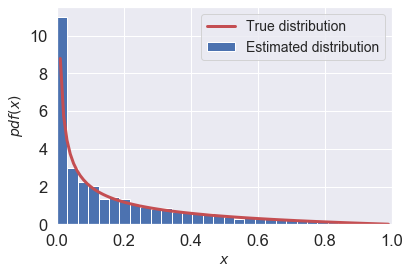

In [21]:
np.random.seed(2)


func = stats.beta(0.4, 2)
samples = metropolis(func=func)
x = np.linspace(0.01, .99, 100)
y = func.pdf(x)
plt.xlim(0, 1)
plt.plot(x, y, 'r-', lw=3, label='True distribution')
plt.hist(samples, bins=32, density=True, label='Estimated distribution')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$pdf(x)$', fontsize=14)
plt.legend(fontsize=14)

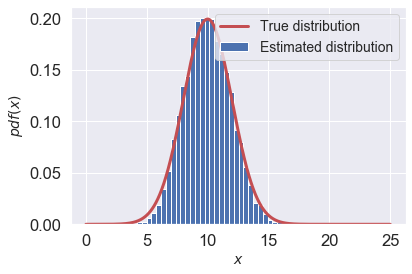

In [22]:
np.random.seed(2)

func = stats.norm(10, 2)
samples = metropolis(func=func)
x = np.linspace(0.01, 25, 1000)
y = func.pdf(x)
# plt.xlim(0, 1)
plt.plot(x, y, 'r-', lw=3, label='True distribution')
plt.hist(samples, bins=32, density=True, label='Estimated distribution')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$pdf(x)$', fontsize=14)
plt.legend(fontsize=14)

In [30]:
def metropolis_extra(func, steps=10000):
    """A very simple Metropolis implementation"""
    samples = np.zeros(steps)
    accept = np.zeros(steps)
    accept2 = np.zeros(steps)

    # start at mean for heck of it
    old_x = func.mean()
    # get the prob density at this point
    old_prob = func.pdf(old_x)
    for i in range(steps):
        # take a small step some direction
        new_x = old_x + np.random.normal(0, 0.5)
        # get the prob density
        new_prob = func.pdf(new_x)
        # compute acceptace parameter
        acceptance = new_prob/old_prob
        accept[i] = acceptance
        # if accepted (bigger than some rangom number)
        # the more better the new point it the higher chance it is accepted
        rnd = np.random.random()
        accept2[i] = rnd
        if acceptance >= rnd:
            # keep the new point and make new the old point
            samples[i] = new_x
            old_x = new_x
            old_prob = new_prob
        else:
            # if rejected keep the old point
            samples[i] = old_x
    return samples, accept, accept2

(array([0.    , 0.1556, 0.    , 1.8444]),
 array([-1. ,  0. ,  0.5,  1. ,  1.5]),
 <a list of 4 Patch objects>)

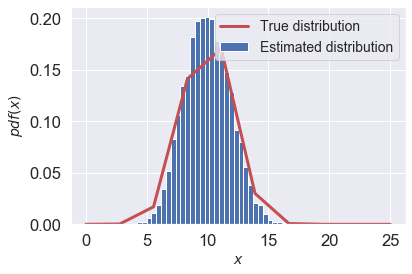

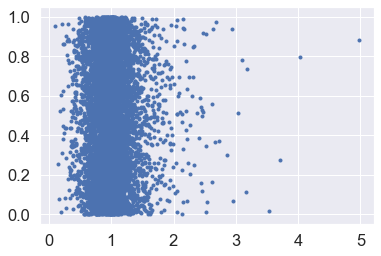

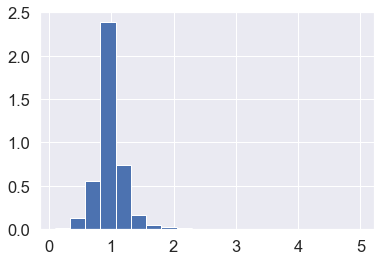

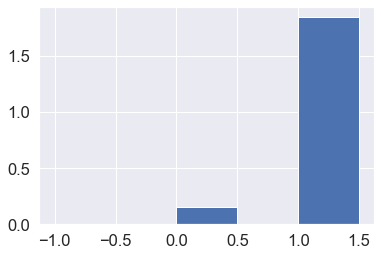

In [45]:
np.random.seed(2)

func = stats.norm(10, 2)
samples, accept, accept2 = metropolis_extra(func=func)
x = np.linspace(0.01, 25, 10)
y = func.pdf(x)
# plt.xlim(0, 1)
plt.plot(x, y, 'r-', lw=3, label='True distribution')
plt.hist(samples, bins=32, density=True, label='Estimated distribution')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$pdf(x)$', fontsize=14)
plt.legend(fontsize=14)

plt.figure()
plt.plot(accept, accept2, '.')


plt.figure()
plt.hist(accept, bins=20, density=True)

plt.figure()
plt.hist((accept>accept2).astype(int), bins=[-1,0, .5,1, 1.5], density=True)

In [44]:
(accept>accept2)

array([ True,  True,  True, ...,  True,  True,  True])